#  Dojo Madness: Oversumo
####  Character: Widowmaker

Hello there,

My name is [Elena](http://datageekette.com/). Let me present you this Notebook which contains an efficient exploratory intro including empirical cumulative distributions, dendrogram of nullity pattern, data filtering and feature creation. It doesn't end there though. 

I continue further with correlation and a zip of regression analysis backed up by cool visualizations with `seaborn`. Right to the end, I run Support Vector Regression to get insights about the construction of the competitive rank of a (widowmaker) player by visualizing top twenty contributing to the algorythm features.

Hope you enjoy the reading!

!["wmaker"](widowmaker1.jpg "widowmaker")

Let's start out data journey:

In [229]:
# loading packages
%matplotlib inline

# manipulation and summaries
import numpy as np
import pandas as pd

# data visualization
import matplotlib.pyplot as plt
import missingno as msno # missing values
import seaborn as sns # advanced vizs
import plotly # tables
import plotly.plotly as py
import plotly.figure_factory as ff

# statistics
from statsmodels.distributions.empirical_distribution import ECDF
from scipy import stats # one way anova
from statsmodels.stats.multicomp import pairwise_tukeyhsd #tukey test

# machine learning
from scipy import stats 
from sklearn.preprocessing import scale 
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer

# importing data
wm = pd.read_csv("widowmaker.csv")
wm.columns

Index(['player_id', 'platform', 'platform_type', 'game_mode', 'timestamp',
       'player_level', 'competitive_rank', 'time_played_total', 'damage_done',
       'death', 'elimination', 'final_blow', 'game_played', 'game_played_raw',
       'game_won', 'game_tied', 'game_lost', 'medal_bronze', 'medal_gold',
       'medal_silver', 'solo_kill', 'time_played', 'time_spent_on_fire',
       'shot_hit', 'shot_fired', 'critical_hit', 'weapon_accuracy',
       'critical_hit_accuracy', 'win_percentage_blizzard',
       'on_fire_percentage', 'winrate', 'multikill', 'objective_kill',
       'melee_final_blow', 'environmental_kill', 'objective_time',
       'hero_specific_stat_1', 'hero_specific_stat_2', 'hero_specific_stat_3',
       'hero_specific_stat_4', 'hero_specific_stat_5', 'hero_specific_stat_6',
       'hero_specific_stat_7', 'hero_specific_stat_8', 'hero_specific_stat_9',
       'hero_specific_stat_10'],
      dtype='object')

For the widowmaker we have folowing specific stats:
- `hero_specific_stat_1`: scoped_accuracy
- `hero_specific_stat_2`: scoped_critical_hit
- `hero_specific_stat_3`: venom_mine_kill
- `hero_specific_stat_4`: scoped_shot
- `hero_specific_stat_5`: scoped_hit

So the rest of `hero_specific_stat` can be dropped.

In [230]:
wm.drop(wm.columns[[-1, -2, -3, -4, -5]], 
        axis = 1, # 1 for columns
        inplace = True) # assigns to the wm dataframe

## I. EDA: Exploratory Data Analysis 

##### As John Tukey, the father of EDA and boxplot, said: 
>  Exploratory data analysis can never be the whole story, but nothing else can serve as the foundation stone. 

In [285]:
# first and last 5 observations
wm.head(5).append(wm.tail(5))

,player_id,platform,platform_type,game_mode,timestamp,player_level,competitive_rank,time_played_total,damage_done,death,...,multikill,objective_kill,melee_final_blow,environmental_kill,objective_time,hero_specific_stat_1,hero_specific_stat_2,hero_specific_stat_3,hero_specific_stat_4,hero_specific_stat_5
0,c5a1ea22ad029a658d6278acd893bf3a,psn,console,competitive_play,1493285137,54,1576.0,104400.0,554.0,2.0,...,NaN,NaN,NaN,NaN,3.0,0.500000,NaN,1.0,6.0,3.0
1,a2464998dd3881c9e96d15f25ceef3b9,xbl,console,competitive_play,1493285106,384,3301.0,331200.0,130710.0,100.0,...,NaN,65.0,2.0,NaN,128.0,0.452892,142.0,36.0,2144.0,971.0
2,947158d783411cd48c131fdee4e44e22,psn,console,competitive_play,1493285103,214,2156.0,32400.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,e615283ff11debbd4cbe6700f11d22bb,pc/us,pc,competitive_play,1493285097,57,1672.0,10800.0,664.0,1.0,...,NaN,NaN,NaN,NaN,NaN,0.571429,NaN,NaN,7.0,4.0
4,34786b7031b5a8cae2f7eb87ea4b501b,psn,console,competitive_play,1493285094,119,2019.0,108000.0,7777.0,7.0,...,NaN,4.0,NaN,NaN,8.0,0.379085,6.0,1.0,153.0,58.0
49995,d9af405ccd3ef68344b5c05050f66f7b,pc/kr,pc,competitive_play,1493242484,114,1417.0,79200.0,3550.0,9.0,...,NaN,1.0,NaN,NaN,NaN,0.393443,1.0,1.0,61.0,24.0
49996,27a2873506686fc23afa89ca6ef36b44,psn,console,competitive_play,1493242483,74,1446.0,72000.0,5752.0,7.0,...,NaN,3.0,NaN,NaN,NaN,0.443548,6.0,NaN,124.0,55.0
49997,2c7bcb3eaaceebc0b68ed2f17fa6fda2,pc/us,pc,competitive_play,1493242483,407,2392.0,183600.0,727.0,NaN,...,NaN,NaN,NaN,NaN,NaN,0.888889,2.0,NaN,9.0,8.0
49998,893a66c06591aaaaffca5c128c2a6f42,pc/us,pc,competitive_play,1493242482,302,2421.0,136800.0,320.0,2.0,...,NaN,NaN,NaN,NaN,NaN,0.300000,NaN,NaN,10.0,3.0
49999,c9b21c831152c227ea1e4a22a5cc1e68,pc/kr,pc,competitive_play,1493242482,361,2345.0,79200.0,63152.0,51.0,...,NaN,27.0,1.0,NaN,98.0,0.507821,76.0,8.0,959.0,487.0


In [286]:
# game_mode values
wm['game_mode'].unique()

array(['competitive_play'], dtype=object)

This variables doesn't add up valuable information to the dataset. We can safely drop it.

In [231]:
wm.drop(wm.columns[3], 
        axis = 1, # 1 for columns
        inplace = True) # assigns to the wm dataframe

Basic summary statistics:

In [289]:
wm.iloc[:, 4:].describe()

,player_level,competitive_rank,time_played_total,damage_done,death,elimination,final_blow,game_played,game_played_raw,game_won,...,multikill,objective_kill,melee_final_blow,environmental_kill,objective_time,hero_specific_stat_1,hero_specific_stat_2,hero_specific_stat_3,hero_specific_stat_4,hero_specific_stat_5
count,50000.000000,49472.000000,5.000000e+04,4.636400e+04,44352.000000,41229.000000,38915.000000,50000.000000,50000.000000,32841.000000,...,3058.000000,32017.000000,6321.000000,60.000000,32283.000000,47067.000000,38060.000000,26150.000000,47067.000000,45729.000000
mean,300.969120,2605.065835,1.710299e+05,3.202465e+04,32.558577,79.468069,53.965309,3.336620,3.378023,2.046192,...,1.806082,27.794859,2.515108,1.016667,80.247716,0.449961,47.388781,10.263021,499.406081,250.816987
std,195.199676,648.693988,1.373438e+05,1.249729e+05,108.709906,307.663986,208.958044,11.897078,11.894178,7.228157,...,2.299323,93.370751,4.558911,0.129099,245.910914,0.147724,188.632841,30.328079,1882.073467,973.969470
min,0.000000,46.000000,4.982411e+01,1.000000e+00,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,156.000000,2173.000000,7.200000e+04,1.423000e+03,2.000000,4.000000,3.000000,0.000000,0.180000,0.000000,...,1.000000,2.000000,1.000000,1.000000,5.000000,0.389831,3.000000,1.000000,24.000000,11.000000
50%,263.000000,2596.000000,1.368000e+05,5.084500e+03,7.000000,13.000000,9.000000,1.000000,0.670000,0.000000,...,1.000000,6.000000,1.000000,1.000000,18.000000,0.461538,8.000000,3.000000,82.000000,40.000000
75%,403.000000,3007.000000,2.376000e+05,1.956150e+04,23.000000,49.000000,33.000000,2.000000,2.340000,1.000000,...,2.000000,19.000000,2.000000,1.000000,61.000000,0.521368,28.000000,8.000000,312.000000,153.000000
max,2430.000000,4805.000000,1.724400e+06,7.078856e+06,5165.000000,17042.000000,11118.000000,569.000000,569.460000,367.000000,...,65.000000,3688.000000,164.000000,2.000000,8408.000000,1.000000,12630.000000,936.000000,107798.000000,54581.000000


Already at this point we can judge the skewness of data distributions:

- `competitive_rank` data is likely to be normally distributed as its mean 2605 and median 2596 are almost equal (mode is equal to 3000)
- first half of `player_level` data is under 263 level with a max of 2430, which shows higly skewed form of distribution
- as well as `game_played` where __the average number of games played (in total) is equal to 3__ with a max of 569.

__The last variable can cause noisy data: players who tried playing a charachter and stopped after few games.__ 

In [ ]:
# grouping variables for further analysis
general = ['player_level', 'platform', 'competitive_rank', 'time_played_total', 'winrate']

colorscale = [[0, '#4E237A'],[.5, '#EFEBF3'],[1, '#ffffff']]
general = ff.create_table( wm.loc[0:6 , general], colorscale = colorscale)
py.iplot(general, filename = 'wm_general')

!["table"](general_first.png "table")

In [ ]:
game = ['game_played', 'game_won', 'game_tied', 'game_lost']
game = ff.create_table( wm.loc[0:6 , game], colorscale = colorscale)
py.iplot(game, filename = 'wm_game')

!["table"](game_first.png "table")

### Gone Missing 

We've seen that we miss quite a lot of data. So what's missing data? 

It's the data that we know exists, but which, due to sparse or incomplete data collection, has no actual value. However for most case there arevariables which don't carry any informational content at all defining the non-data term. This means that when answering the question "is this data entry filled?" one must actually consider three possible answers: "Yes", "No, but it can be", and "No, and it cannot be".

There are two types of missing data: the one that occurs at random - nullity pattern - and not at random. In the first case of having a sufficiently large number of observations we can safely drop these observations using `drop()`.

Far more troubling, when data not missing at random, dropping the data and modeling what's left would result in falsehoods, as we will ignore a potentially important information.

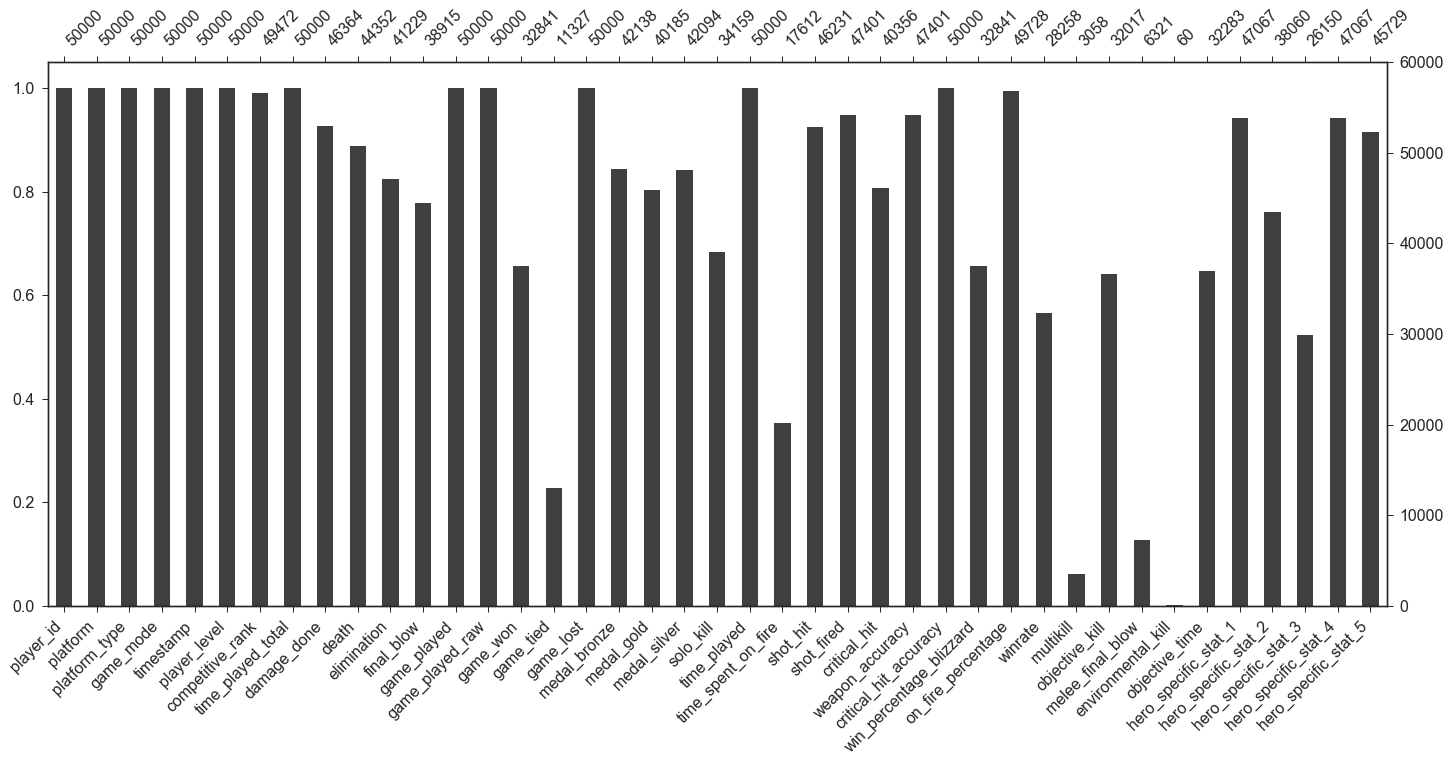

In [4]:
sns.set(style = "ticks")
msno.bar(wm)

In this specific case most of the missing values could be considered as 'no available information' - non data - and thus dropped. However there are a few variables that should have data like `cometitive_rank` or `damage_done`. At least zeros in both cases. 

In [290]:
# na's in competitive rank
wm[np.isnan(wm['competitive_rank'])].head(5)

,player_id,platform,platform_type,timestamp,player_level,competitive_rank,time_played_total,damage_done,death,elimination,...,multikill,objective_kill,melee_final_blow,environmental_kill,objective_time,hero_specific_stat_1,hero_specific_stat_2,hero_specific_stat_3,hero_specific_stat_4,hero_specific_stat_5
24,ff9ab65717d8bd4c7a185281698d0588,xbl,console,1493284955,160,NaN,104400.0,2358.0,8.0,11.0,...,1.0,3.0,NaN,NaN,29.0,0.257143,1.0,7.0,35.0,9.0
287,b65c5864821f2003321839b233bc6398,pc/us,pc,1493284860,604,NaN,3060.0,2538.0,3.0,3.0,...,NaN,1.0,NaN,NaN,1.0,0.607143,3.0,NaN,28.0,17.0
485,8ebe283cb0bd3364ba0dbf70a09f625e,pc/us,pc,1493284777,196,NaN,50400.0,4421.0,5.0,9.0,...,NaN,1.0,NaN,NaN,NaN,0.344828,11.0,NaN,87.0,30.0
788,f83c2014cc263fd7c98131e7329296db,psn,console,1493284543,56,NaN,1380.0,178.0,1.0,NaN,...,NaN,NaN,NaN,NaN,4.0,0.333333,NaN,NaN,6.0,2.0
814,909a72bb8b2e201f7e8c678e294da579,pc/us,pc,1493284501,200,NaN,7200.0,3864.0,16.0,9.0,...,NaN,2.0,NaN,NaN,5.0,0.258503,NaN,1.0,147.0,38.0


In [291]:
# na's in competitive rank
wm[np.isnan(wm['damage_done'])].head(5)

,player_id,platform,platform_type,timestamp,player_level,competitive_rank,time_played_total,damage_done,death,elimination,...,multikill,objective_kill,melee_final_blow,environmental_kill,objective_time,hero_specific_stat_1,hero_specific_stat_2,hero_specific_stat_3,hero_specific_stat_4,hero_specific_stat_5
2,947158d783411cd48c131fdee4e44e22,psn,console,1493285103,214,2156.0,32400.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6557cc23fc5f6680424886e078034e22,pc/us,pc,1493285077,254,1830.0,36000.0,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1.0,NaN
9,bd83d285f3804eea287673096d05ce76,psn,console,1493285001,490,2410.0,295200.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,00a834229821959a9f21c342402f3c4d,psn,console,1493284998,105,2007.0,64800.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
61,b9acb29111d35d6c2cbee970cf718eb6,psn,console,1493284944,202,2467.0,32400.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


For some unknown reasons some playes were not attributed neither a rank nor the volume of done damage even though their total played game is not null. We can check by the use of dendrogram if the variable completion is correlated to any other variables and possibly reveal unseen trends:

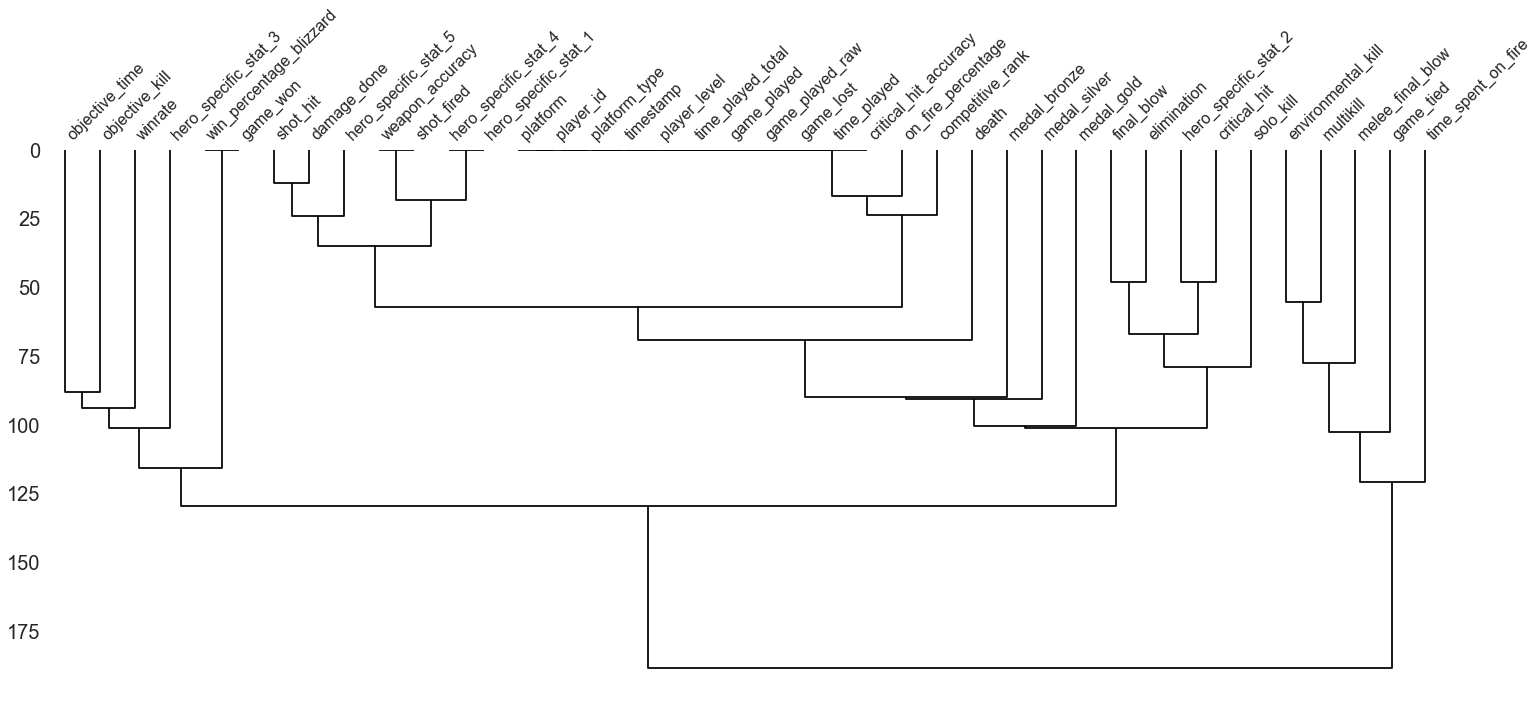

In [292]:
msno.dendrogram(wm)

To interpret this graph we read from a top-down perspective. Cluster leaves which linked together predict one another's presence — one variable might always be empty when another is filled, or they might always both be filled or both empty, and so on. 

By looking at the `competitive_rank`, its completion depends on the `on_fire_percentage` paired with `critical_hit_accuracy` and variables (in the middle) like `platform`, `platform_type`, `player_id`, `time_played_raw `and so on, which also predict availability of each other. 

In [293]:
# na's in competitive rank for on_fire_percentage and critical_hit_accuracy
_ = wm.loc[:, ['competitive_rank', 'on_fire_percentage', 'critical_hit_accuracy', 'time_played', 'time_played_raw']]
_[np.isnan(wm['competitive_rank'])].head(5)

,competitive_rank,on_fire_percentage,critical_hit_accuracy,time_played,time_played_raw
24,NaN,0.000000,0.011236,420.000000,NaN
287,NaN,0.000000,0.136364,120.000000,NaN
485,NaN,0.027778,0.233333,360.000000,NaN
788,NaN,0.000000,0.000000,52.282848,NaN
814,NaN,0.000000,0.042105,960.000000,NaN


Indee for almost zero `on_fire_percentage` and with no information of `time_played_raw` there is no data on the `competitive_rank` of a player.

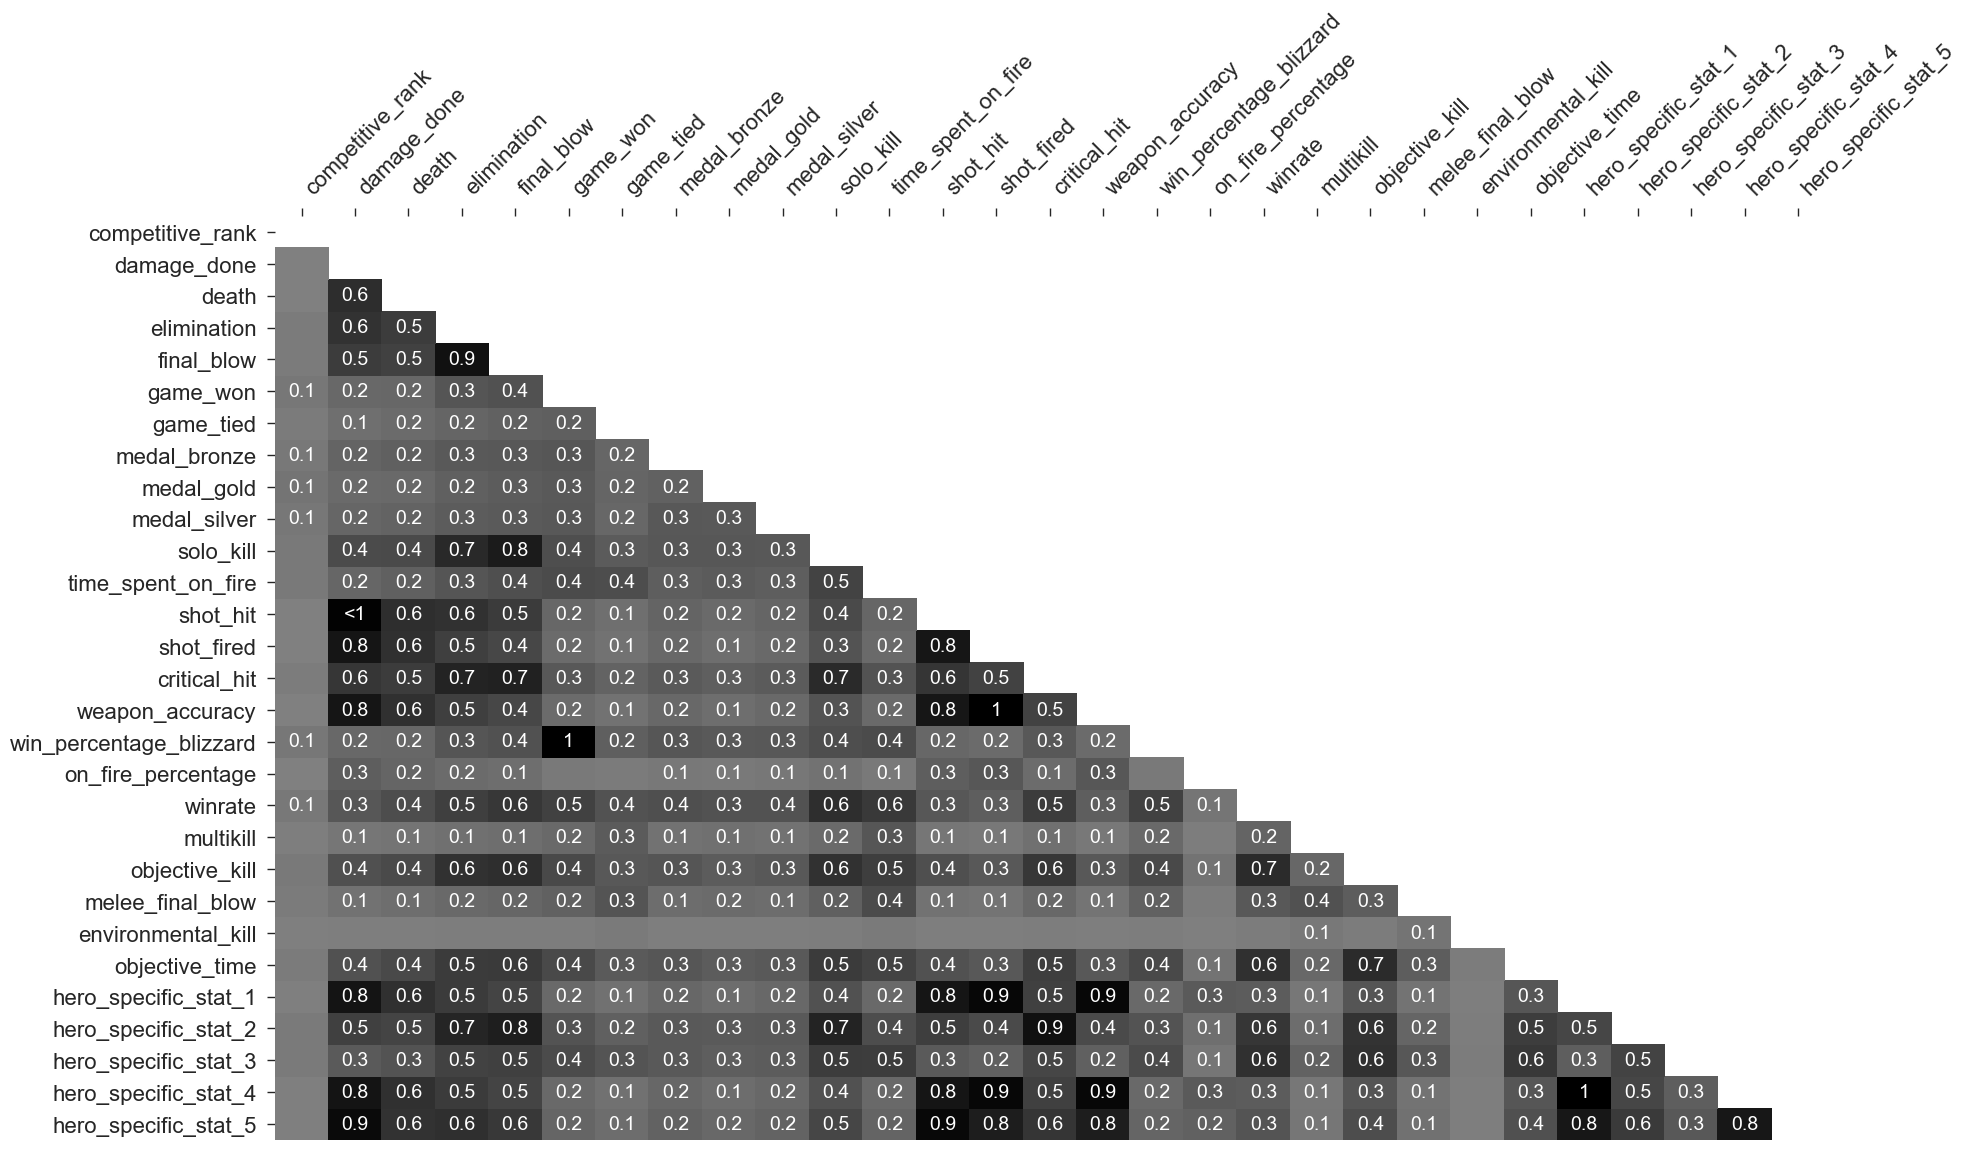

In [238]:
# nullity pattern
msno.heatmap(wm, cmap = 'binary') 

We see here as well as obvious correlations, such as if there's a `game_won` than `win_percentage_blizzard` is also present, and less obvious ones, like high correlaions between `hero_specific_stat_5`, `hero_specific_stat_4`, `hero_specific_stat_1` and `damage_done`, which reveal the usage of most frequent skills.

For now, we leave missing valuea as they are to see if we can come up with the filter-solution which could eliminate most if the NaNs.

### ECDF: empirical cumulative distribution function 

Why is the Empirical Cumulative Distribution useful in Exploratory Data Analysis?

- it approximates the true CDF well if the sample size (the number of data) is large and knowing the distribution is helpful for statistical inference 
- it can visually display “how fast” the ECDF increases to 1.0
- plotting key quantiles like the quartiles is useful to get a feel for the data

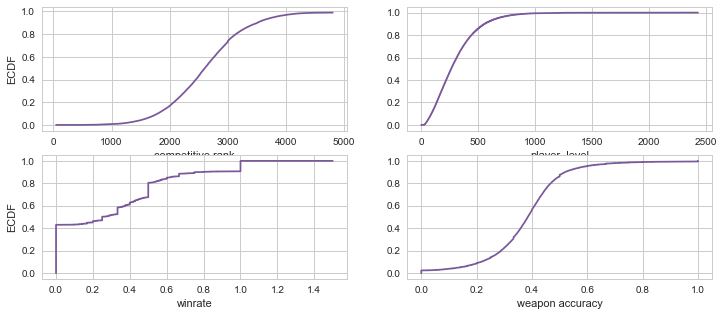

In [211]:
sns.set(style = "whitegrid")
plt.figure(figsize = (12, 5)) # for subplots

plt.subplot(221)
cdf = ECDF(wm['competitive_rank'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = '#795999');
plt.xlabel('competitive rank'); plt.ylabel('ECDF');

# plot second ECDF  
plt.subplot(222)
cdf = ECDF(wm['player_level'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = '#795999');
plt.xlabel('player_level');

# plot third ECDF  
plt.subplot(223)
cdf = ECDF(wm['winrate'].dropna()) # to achieve 100%
plt.plot(cdf.x, cdf.y, label = "statmodels", color = '#795999');
plt.xlabel('winrate'); plt.ylabel('ECDF');

# plot third ECDF  
plt.subplot(224)
cdf = ECDF(wm['weapon_accuracy'].dropna())
plt.plot(cdf.x, cdf.y, label = "statmodels", color = '#795999');
plt.xlabel('weapon accuracy');

Short summary of the plots above. Read from top left to bottom right:
1. The 80% of the ranks are less than 3000 and almost all competitive ranks are between 1000 and 4000.
2. About 90% of players have levels lower than 500.
3. For about 40% of players the winrate is equal to zero and for 90% - less than 1.0.
4. More than a half of players (60%) have less than 0.4 weapon accuracy.

### II. Feature Engineering and Data Selection

#### - Missing: platforms 

Check the data distribution for the categorical variable `platform`:

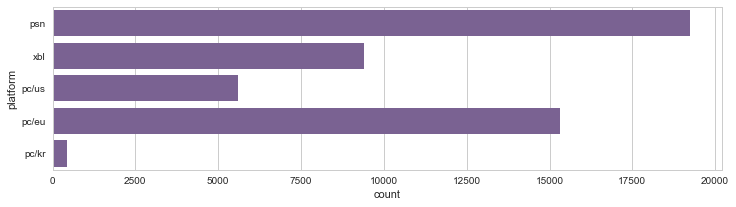

In [205]:
f, ax = plt.subplots(figsize = (12, 3))
sns.countplot(y = 'platform', data = wm, color = '#7A5A9A')

Sadly enough we have almost no data on South Korean PC platform. It makes sense to drop it for further analysis.

In [232]:
wm.drop(wm[wm.platform == 'pc/kr'].index, 
        inplace = True)

#### - Per unit of `time_played` (min and sec)

Short description of time variables:
- `time_played`: the time value in seconds for a whole period of playing a widowmaker.
- `time_played_total`: the time value in seconds for a whole period of playing (for an account)

In [233]:
# to minutes
wm['time_played_min'] = wm['time_played'] / 60

print('On average a player plays for widowmaker', 
      round(wm.time_played_min.mean(), 2), 
      'minutes out of the total time played.')

On average a player plays for widowmaker 35.3 minutes out of the total time played.


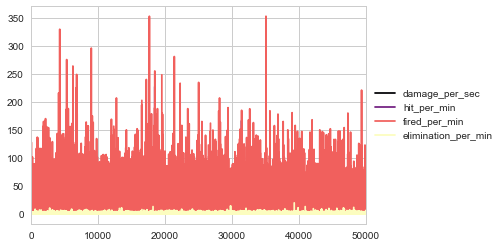

In [234]:
wm['damage_per_sec'] = wm['damage_done'] / wm['time_played'] 
wm['hit_per_min'] = wm['shot_hit'] / wm['time_played_min'] 
wm['fired_per_min'] = wm['shot_fired'] / wm['time_played_min'] 
wm['elimination_per_min'] = wm['elimination'] / wm['time_played_min']

# plot distributions
ax = wm[['damage_per_sec', 'hit_per_min', 'fired_per_min', 'elimination_per_min']].plot(cmap = 'magma')
ax.legend(loc = 'center left', bbox_to_anchor = (1, 0.5));

It is clear from the profile plot that the mean and standard deviation for `fired_per_min` is a lot higher than that for the other variables.

#### - Low popularity of a widowmaker charachter

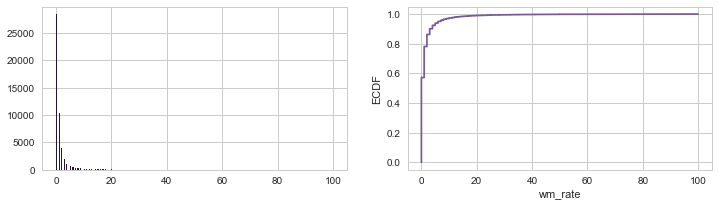

In [235]:
plt.figure(figsize = (12, 3))

# part of time played as a widowmaker to the whole period
wm['wm_rate'] = round(wm['time_played'] / wm['time_played_total'] * 100)

# overall distribution
plt.subplot(121)
plt.hist(wm['wm_rate'].dropna(), 
         bins = int(np.sqrt(len(wm['wm_rate']))), # n of bins = square root of number of obs.
         color = '#241440');

# plot third ECDF  
plt.subplot(122)
cdf = ECDF(wm['wm_rate'].dropna()) # to achieve 100%
plt.plot(cdf.x, cdf.y, label = "statmodels", color = '#795999');
plt.xlabel('wm_rate'); plt.ylabel('ECDF');

Indeed, widowmaker charachter is not the most popular one. About 80% of players don't play it at all. Let's look at another extreme of the variable:

In [298]:
# top 10 of those who play only widowmaker 
# sorted by level
wm.loc[:, ['wm_rate', 'player_level', 'competitive_rank']].sort_values(
    by = ['wm_rate', 'player_level'], ascending = False).head(10)

,wm_rate,player_level,competitive_rank
29187,100.0,451,NaN
40572,100.0,275,2012.0
25961,100.0,264,NaN
47066,100.0,154,1593.0
18995,100.0,145,NaN
41287,100.0,143,1850.0
17657,100.0,104,2788.0
22191,100.0,63,3176.0
4466,100.0,58,2388.0
37897,100.0,58,2388.0


#### - Won per game = winrate?

In [236]:
wm['won_per_game'] = wm['game_won'] / wm['game_played']
wm.loc[:, ['winrate', 'won_per_game']].describe()

,winrate,won_per_game
count,28002.000000,24046.000000
mean,0.302053,0.340806
std,0.323119,0.321479
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.250000,0.333333
75%,0.500000,0.500000
max,1.500000,1.000000


Almost identical. Though winrate of 150% out of 100% seems pretty impossible percentage. 

As disscused before, the number of games has higly spread distribution with an average number of games of 3. So I assumed that mst of the players were only trying the widowmaker and not continiung any further. This assumption was succesfully prooved by the low popularity of a charachter. 

<div class="alert alert-block alert-info"> For the further analysis I take only those players, who played at widowmaker at least 5% of their total time in the game. The size of the sample will definetly shrink, because almost 80% of players don't play the charachter, but we will decrease the variance of the dataset and it will be still large enough for any inferences on the dataset. </div>

In [237]:
wm = pd.DataFrame(wm[wm['wm_rate'] >= 5])
wm.loc[:, ['player_level', 'won_per_game']].describe()

,player_level,won_per_game
count,3778.000000,3422.000000
mean,247.308629,0.454812
std,202.854372,0.209596
min,0.000000,0.000000
25%,92.000000,0.333333
50%,193.000000,0.461538
75%,351.000000,0.545455
max,1834.000000,1.000000


The size of sample was drastically shrinked but still quite large - 3778 observations. But the standard deviation of `won_per_game` also fell down from 0.32 to 0.21.

#### - `death ` into `life` 

We can also think of player's achievements in terms of games and lifes. Let's first look at the distribution of the variable of interest: `death` total number of deaths per each player.

In [305]:
wm.loc[:, 'death'].describe()

count    3769.000000
mean      192.680021
std       314.696187
min         1.000000
25%        26.000000
50%        92.000000
75%       236.000000
max      5165.000000
Name: death, dtype: float64

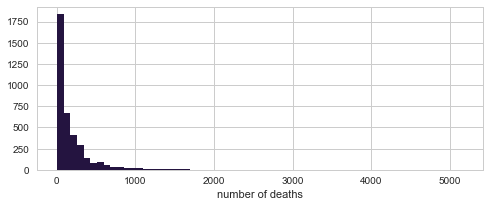

In [218]:
plt.figure(figsize = (8, 3))

plt.hist(wm['death'].dropna(), 
         bins = int(np.sqrt(len(wm['death']))), # n of bins = square root of number of obs.
         color = '#241440'); 
plt.xlabel('number of deaths');

So what's the opposite of death? Not going deeper into philosophy - most probably it is life. We know that after each death a player can respawn infinite number of times until the end of a session. So based on `death` we can deduct a total number of lifes per player: `life` = `death` + 1.

In [238]:
# life:death +1 (for every respawn after death)
wm['life'] = wm['death'] + 1 

# dropping death variable
wm.drop('death', 1, inplace = True)

# new variable
wm['damage_per_life'] = wm['damage_done'] / wm['life']

# summary for new variables
wm.loc[:, ['life', 'damage_per_life', 'damage_per_sec']].describe() 

,life,damage_per_life,damage_per_sec
count,3769.000000,3769.000000,3776.000000
mean,193.680021,1048.740563,13.730208
std,314.696187,447.620026,4.574536
min,2.000000,20.375000,0.679167
25%,27.000000,771.261905,10.991111
50%,93.000000,1030.169591,13.783659
75%,237.000000,1287.320755,16.170669
max,5166.000000,5507.500000,36.586389


- On average each player (among frequent widowmaker players) respawn 193 times.
- On average there's 1050 damage done per each life with max of 10350.
- Which gives on average 13 units of damage per second.

Let's add more `per_life` variables:

In [239]:
wm['crit_per_life'] = wm['critical_hit'] / wm['life']
wm['hit_per_life'] = wm['shot_hit'] / wm['life']
wm['solo_per_life'] = wm['solo_kill'] / wm['life']

_ = ['damage_per_life', 'crit_per_life', 'hit_per_life', 'solo_per_life']

wm.loc[:, _].describe()

,damage_per_life,crit_per_life,hit_per_life,solo_per_life
count,3769.000000,3738.000000,3769.000000,3638.000000
mean,1048.740563,1.848203,14.927403,0.667957
std,447.620026,0.859886,6.520554,0.347582
min,20.375000,0.037958,0.333333,0.015707
25%,771.261905,1.304348,10.931034,0.454041
50%,1030.169591,1.760000,13.928571,0.627963
75%,1287.320755,2.280590,17.562500,0.830838
max,5507.500000,7.571429,92.000000,4.428571


### Handling missing values

Let's check again what we miss:

In [ ]:
wm.isnull().sum()

!["nan"](nans.png "nan")

We still have quite a lot of missing information, but it's way less compared to what was before. NaNs in variables like `environmental_kill`, `multikill`, `game_tied`, `melee_final_blow` and all `hero_specific_stat_` can be replaced with zeros - there're simply no information provided.

In [240]:
zeros = ['environmental_kill', 'multikill', 'game_tied', 'melee_final_blow', 
         'hero_specific_stat_1', 'hero_specific_stat_2', 'hero_specific_stat_3', 'hero_specific_stat_4', 'hero_specific_stat_5']

wm[zeros] = wm[zeros].fillna(0)

Plot the dedrogram again:

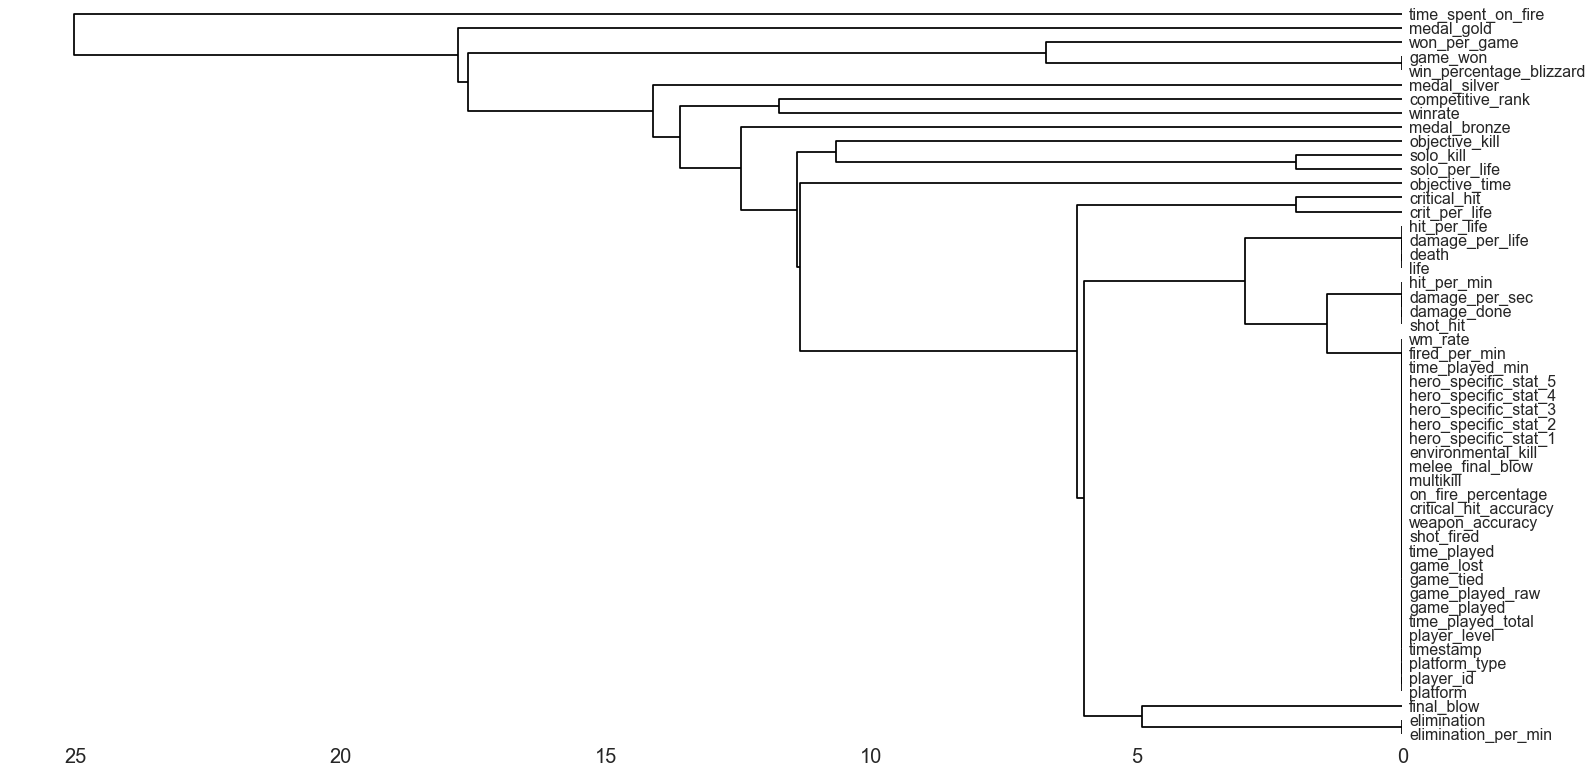

In [310]:
# more variables
msno.dendrogram(wm)

We see that `time_spent_on_fire` (with 669 missing values), `medal_gold`, `game_won` and  `win_percentage_blizzard` are tied together. The rest of the variables are related to the comletion of these four. 

In [242]:
missing = ['time_spent_on_fire', 'medal_gold', 'game_won', 'win_percentage_blizzard']

# medal_gold and others with time_spent_on_fire missing
wm[missing][np.isnan(wm['time_spent_on_fire'])].head(5)

,time_spent_on_fire,medal_gold,game_won,win_percentage_blizzard
58,NaN,NaN,1.0,0.90
69,NaN,0.0,NaN,NaN
100,NaN,1.0,1.0,1.00
102,NaN,0.0,1.0,0.33
108,NaN,1.0,0.0,0.25


In [243]:
# game_won and blizzard for medal_gold equal to 0
wm[wm.medal_gold == 0][missing].head()

,time_spent_on_fire,medal_gold,game_won,win_percentage_blizzard
35,172.0,0.0,1.0,0.72
69,NaN,0.0,NaN,NaN
102,NaN,0.0,1.0,0.33
1153,NaN,0.0,NaN,NaN
1172,NaN,0.0,1.0,0.51


We can safely replace all missing values by zeros as we don't see any specific patterns in the data.

In [316]:
wm.iloc[:, 4:].describe()

,player_level,competitive_rank,time_played_total,damage_done,death,elimination,final_blow,game_played,game_played_raw,game_won,...,hit_per_min,fired_per_min,elimination_per_min,wm_rate,won_per_game,life,damage_per_life,crit_per_life,hit_per_life,solo_per_life
count,3778.000000,3557.000000,3.778000e+03,3.776000e+03,3769.000000,3749.000000,3725.000000,3778.000000,3778.000000,3467.000000,...,3776.000000,3778.000000,3749.000000,3778.000000,3422.000000,3769.000000,3769.000000,3738.000000,3769.000000,3638.000000
mean,247.308629,2491.978353,1.273624e+05,2.164853e+05,192.680021,501.850093,329.873826,22.495236,22.515095,11.404673,...,11.842001,30.038612,1.885005,12.163843,0.454812,193.680021,1048.740563,1.848203,14.927403,0.667957
std,202.854372,747.477278,1.421161e+05,3.759353e+05,314.696187,884.018543,587.612865,36.155441,36.186449,19.062227,...,4.196323,11.253429,0.686226,11.621987,0.209596,314.696187,447.620026,0.859886,6.520554,0.347582
min,0.000000,500.000000,4.982411e+01,1.200000e+02,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,1.000000,3.463120,0.133333,5.000000,0.000000,2.000000,20.375000,0.037958,0.333333,0.015707
25%,92.000000,1951.000000,2.520000e+04,2.171975e+04,26.000000,53.000000,33.000000,3.000000,3.190000,2.000000,...,9.256681,22.941111,1.487500,6.000000,0.333333,27.000000,771.261905,1.304348,10.931034,0.454041
50%,193.000000,2497.000000,6.840000e+04,9.840350e+04,92.000000,233.000000,148.000000,11.000000,11.150000,6.000000,...,11.174078,27.622083,1.875000,8.000000,0.461538,93.000000,1030.169591,1.760000,13.928571,0.627963
75%,351.000000,3000.000000,1.944000e+05,2.551338e+05,236.000000,593.000000,386.000000,27.000000,27.207500,13.000000,...,13.663889,34.084856,2.221429,13.000000,0.545455,237.000000,1287.320755,2.280590,17.562500,0.830838
max,1834.000000,4596.000000,1.220400e+06,7.078856e+06,5165.000000,17042.000000,11118.000000,569.000000,569.460000,367.000000,...,43.666667,137.083333,6.150000,100.000000,1.000000,5166.000000,5507.500000,7.571429,92.000000,4.428571


In [244]:
wm.replace(np.inf, np.nan) # replace infinite values with NaNs
wm.fillna(0, inplace = True) # fill NaNs with 0

## III. Correlation and Regression Analysis

> ... no causation is implied, simply association.

<div class="alert alert-block alert-info"> I draw an attention on the fact that in the last section I filtered the data based on the percentage played by the widowmaker to the whole time spent in the game (wm_rate > 5) in order to get rid of unwanted noise and lower the variance in the dataset.</div>

#####  Questions to answer: 
- What are the overall correlations? How strong they are? 
- How `competitive rank`, `player_level`, `total_time_played` and `game_played` differ from one `platform` to another? 
- Which variables are correlated to the `competitive_rank` and contribute the most to it change?

We are likely to see an increase in variables such as `damage_done`, `critical_hit`, `death`, `shot_fired` with an increase in `time_played`. But these correlations are pretty obvious. What we want to catch though are hidden patterns per every unit of change in a particular variable. Like we computed before: `per_sec`, `per_min`, `per_game` and `per_life`. 

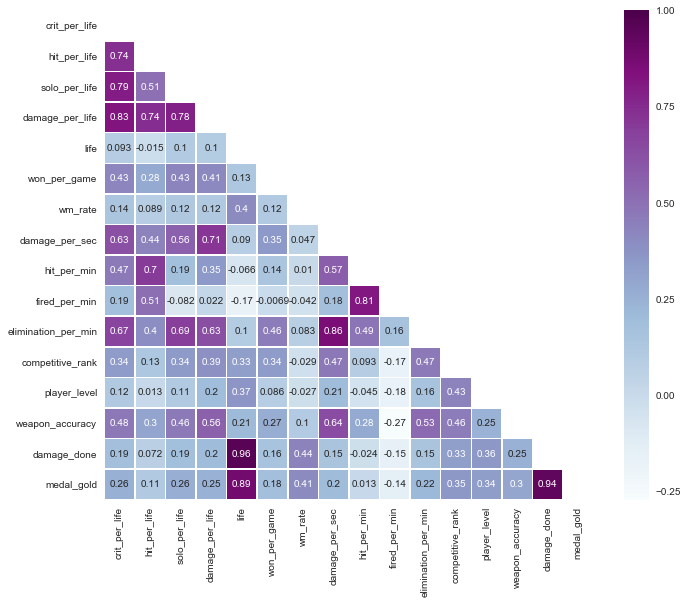

In [245]:
new_var = ['crit_per_life', 'hit_per_life', 'solo_per_life', 'damage_per_life', 'life',
           'won_per_game', 'wm_rate', 'damage_per_sec', 'hit_per_min', 'fired_per_min', 'elimination_per_min']

# Compute the correlation matrix
corr_all = wm[new_var + ['competitive_rank', 'player_level', 
                         'weapon_accuracy', 'damage_done', 'medal_gold']].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_all, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize = (11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_all, mask = mask, annot = True,
            square = True, linewidths = .5, ax = ax, cmap = 'BuPu')      
plt.show()

We are mostly interested in correlations with `competitive_rank` and `player_level`:
- `competitive_rank` seems to be positively and linearly correlated to `damage_per_sec` (0.47), `elimination_per_min` (also 0.47) and `weapon_accuracy` (0.46)
- `player_level`, on the other hand, has no strong positive correlation, except for the `competitive_rank` itself. 

#### - `competitive_rank` and `damage_per_sec`

Correlation between `competitive_rank` and `damage_per_sec`:

In [354]:
# how strong the correlation is
_ = stats.pearsonr(wm.competitive_rank, wm.damage_per_sec)
print("p-value:\t", _[1])
print("cor:\t\t", _[0])

p-value:	 1.38816712259e-210
cor:		 0.473640148196


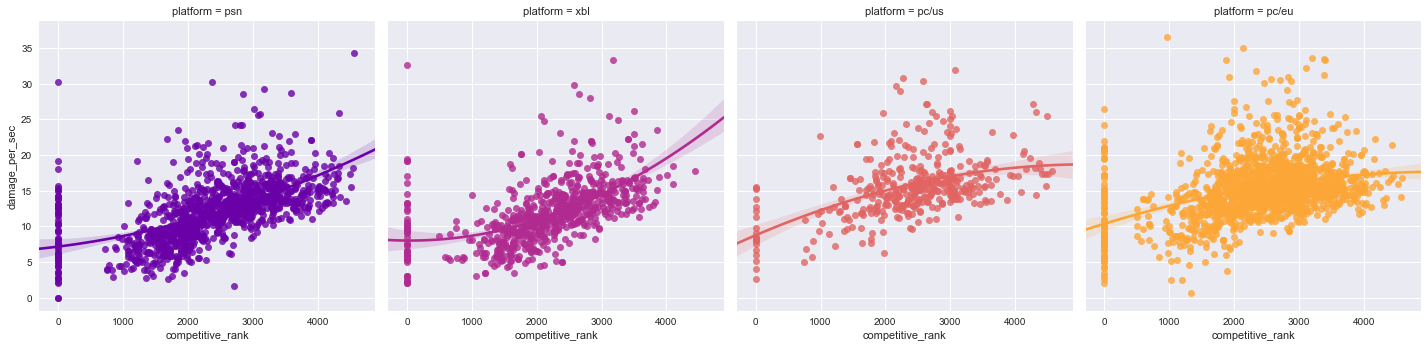

In [19]:
sns.lmplot('competitive_rank', 'damage_per_sec', wm, 
           hue = 'platform', col = 'platform',  palette = 'plasma', 
           fit_reg = True,
           order = 2);

Let's have a look at the hero specific stats and how they are correlated to each other and damage_done variable. Here is a quick reminder of widowmaker's specific skills and stats:
- `hero_specific_stat_1` = scoped accuracy
- `hero_specific_stat_2` = scoped critical hit
- `hero_specific_stat_3` = venom mine kill
- `hero_specific_stat_4` = scoped shot
- `hero_specific_stat_5` = scoped hit

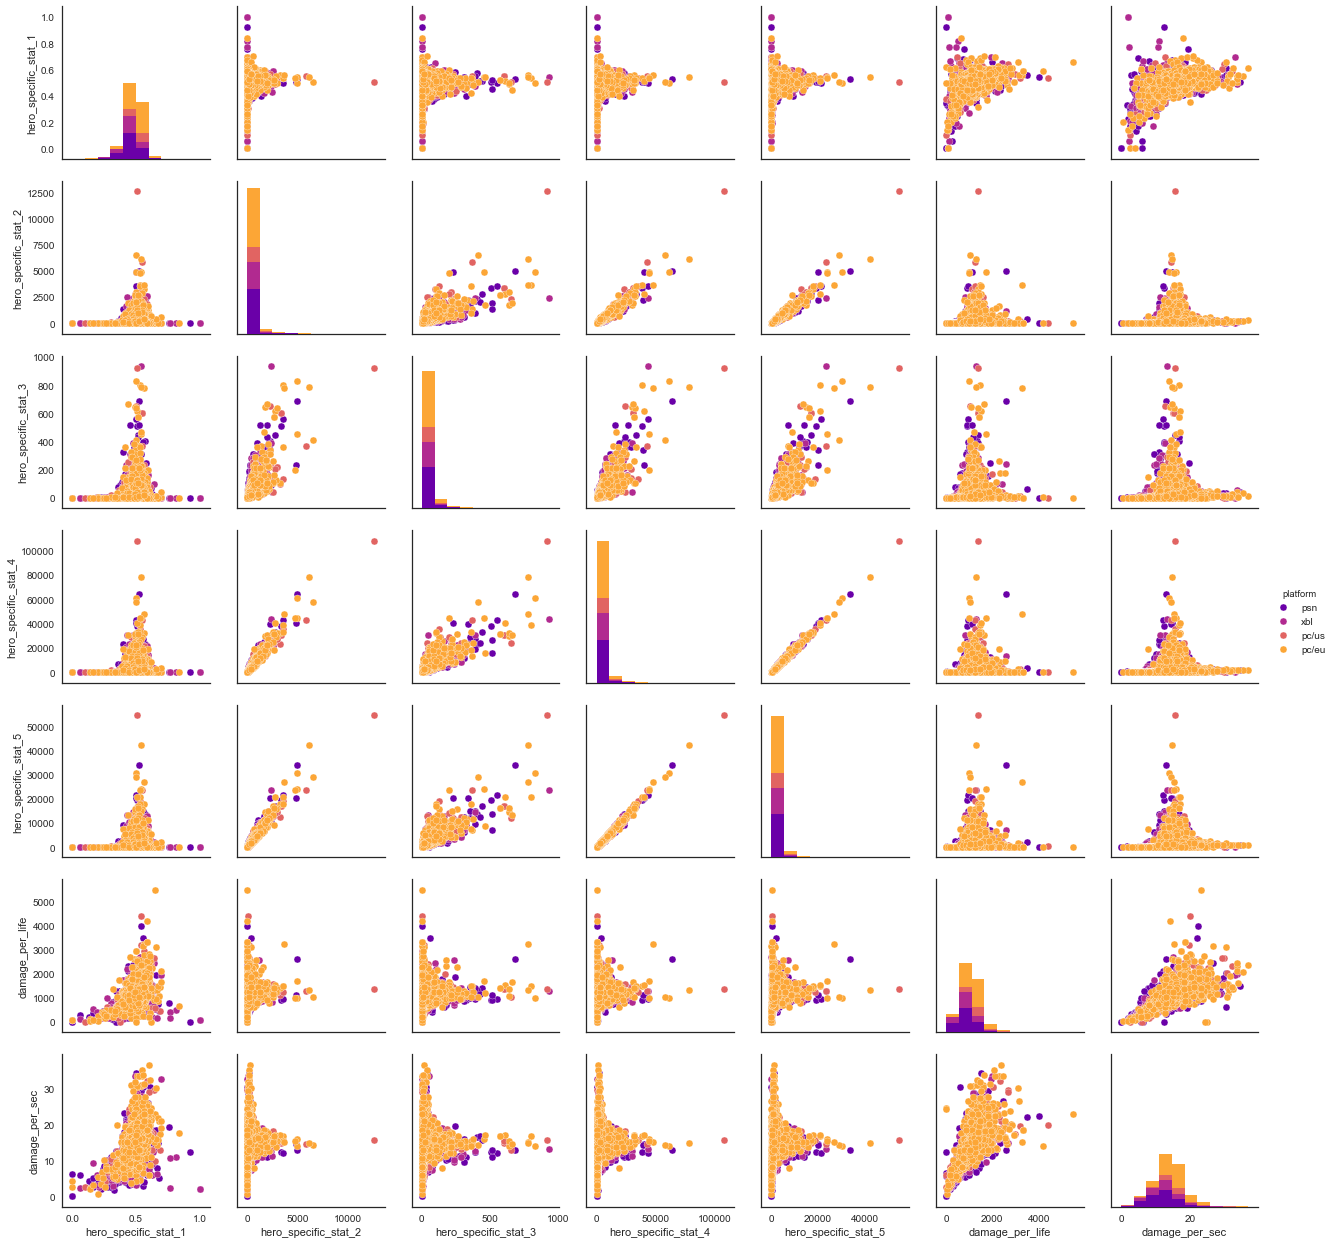

In [359]:
skills = ['hero_specific_stat_1', 'hero_specific_stat_2', 'hero_specific_stat_3',
       'hero_specific_stat_4', 'hero_specific_stat_5']

sns.pairplot(wm.loc[:, skills + ['platform', 'damage_per_life', 'damage_per_sec']], 
             hue = 'platform',
             palette = 'plasma')

Scoped shot (hss4) and scoped hit (hss5) are both in strong positive linear relationship with each other, as well as scoped shot and scoped critical hit (hss2). Apart from that, there's no strong linear correlations between selected variables.

#### - Platforms

Let's now take a closer look at one of the very few categorical variables in the dataset: `platform`. It would be interesting to see how the averages of main metrics like `player_level`, `competitive_rank` etc, differ from a platform to another.

In [364]:
wm.loc[:, general].groupby('platform').mean()

,player_level,competitive_rank,time_played_total,winrate
platform,,,,
pc/eu,265.039533,2410.370706,135274.335710,0.448361
pc/us,290.219451,2414.770574,139289.925187,0.477437
psn,242.580334,2349.269535,126491.896246,0.394289
xbl,190.933813,2159.171223,104341.208633,0.403235


Users of xbox have least impressive numbers.

## IV. Analysis of Variances 

ANOVA is a statistical inference test that lets us compare multiple groups at the same time. By its use we can check whether numeric response variables, __player level and competitive rank__, varie according to the levels of a categorical variable, __platform__. 

In [379]:
pc_eu1 = wm.loc[:, 'player_level'][wm.platform == 'pc/eu']
pc_us1 = wm.loc[:, 'player_level'][wm.platform == 'pc/us']
psn1 = wm.loc[:, 'player_level'][wm.platform == 'psn']
xbl1 = wm.loc[:, 'player_level'][wm.platform == 'xbl']

stats.f_oneway(pc_eu1, pc_us1, psn1, xbl1)  

F_onewayResult(statistic=28.623780064359043, pvalue=2.6995045469003403e-18)

In [368]:
pc_eu2 = wm.loc[:, 'competitive_rank'][wm.platform == 'pc/eu']
pc_us2 = wm.loc[:, 'competitive_rank'][wm.platform == 'pc/us']
psn2 = wm.loc[:, 'competitive_rank'][wm.platform == 'psn']
xbl2 = wm.loc[:, 'competitive_rank'][wm.platform == 'xbl']

stats.f_oneway(pc_eu2, pc_us2, psn2, xbl2) 

F_onewayResult(statistic=12.617695553283406, pvalue=3.3205397917876814e-08)

Both tests results suggest that the groups don't have the same sample means, since the p-value is significant at a 99% confidence level. To check which groups differ after getting a positive ANOVA result, we can perform one of the most common follow up test - Tukey's test.

group1,group2,meandiff,lower,upper,reject
pc/eu,pc/us,25.1799,-3.7286,54.0885,False
pc/eu,psn,-22.4592,-42.6066,-2.3118,True
pc/eu,xbl,-74.1057,-97.6664,-50.545,True
pc/us,psn,-47.6391,-77.5866,-17.6917,True
pc/us,xbl,-99.2856,-131.6282,-66.9431,True
psn,xbl,-51.6465,-76.4709,-26.8221,True


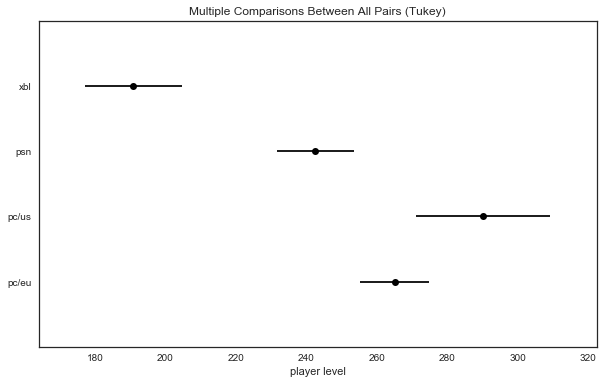

In [53]:
sns.set(style = 'white')
tukey = pairwise_tukeyhsd(endog = wm['player_level'], # player levels
                          groups = wm.platform,   
                          alpha = 0.05) # 95% CI       

# Plot group confidence intervals
tukey.plot_simultaneous()    
plt.vlines(x = 49.57, ymin = -0.5, ymax = 4.5)
plt.xlabel('player level')

# See test summary
tukey.summary()              

The output of the Tukey test shows the average difference, a confidence interval as well as whether we should retain/reject the null hypothesis for each pair of platforms at the given significance level. 

In the case of `player_level` data, the test suggest to reject the null hypothesis for almost every pair except for the pair PC/EU and PC/US. Which means that __almost every platform is significantly different from the other__ (in terms of player levels) and the 95% confidence interval plot reinforces the results visually: only two CI are overlaping.

group1,group2,meandiff,lower,upper,reject
pc/eu,pc/us,4.3999,-129.2146,138.0143,False
pc/eu,psn,-61.1012,-154.2216,32.0193,False
pc/eu,xbl,-251.1995,-360.0963,-142.3027,True
pc/us,psn,-65.501,-203.9172,72.9151,False
pc/us,xbl,-255.5994,-405.0856,-106.1131,True
psn,xbl,-190.0983,-304.8359,-75.3607,True


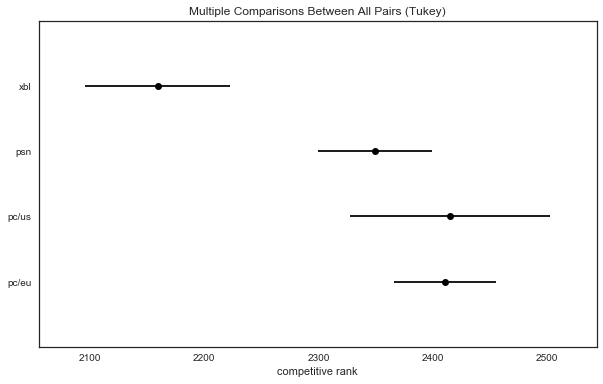

In [54]:
tukey = pairwise_tukeyhsd(endog = wm['competitive_rank'], # competitive rank
                          groups = wm.platform, 
                          alpha = 0.05) # 95% CI         

# Plot group confidence intervals
tukey.plot_simultaneous()    
plt.vlines(x = 49.57, ymin = -0.5, ymax = 4.5)
plt.xlabel('competitive rank')

# See test summary
tukey.summary()          

The test suggests rejecting the null hypothesis for every pair with __Xbox__, the same as for the `player_level`, and fail to reject every other. 

We can conclude that PC and PlayStation players share the same competitivity characteristics. Not the same story for player levels though: PC users are the highest-level players.

## V. Support Vector Regression

Question to answer: __Which variables contribute the most to the competitive rank of a player?__

### Preprocessing

Many elements used in the objective function of a learning algorithm (such as the RBF kernel of Support Vector Machines or the l1 and l2 regularizers of linear models) assume that all features are centered around zero and have variance in the same order. 

If a feature has a variance that is much larger than others, it might dominate the objective function and make the estimator unable to learn from other features correctly as expected.

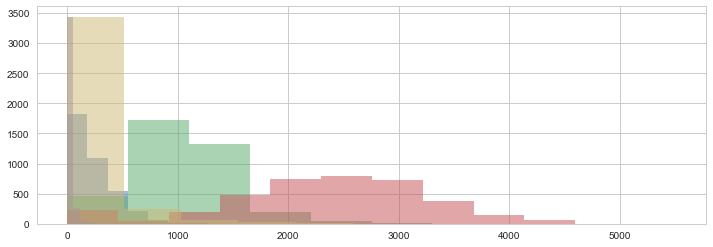

In [224]:
sns.set(style = 'whitegrid')
plt.figure(figsize = (12, 4))

# distributions
plt.hist(wm.player_level, alpha = 0.5)
plt.hist(wm.damage_per_life, alpha = 0.5)
plt.hist(wm.competitive_rank, alpha = 0.5)
plt.hist(wm.game_played, alpha = 0.5)
plt.hist(wm.life, alpha = 0.5)
plt.show()

I plotted only those features which could be plotted together. Most of the features, like `time_played`, dominate the plotting space. We definetely need to standardize.

At first though, we need to srop highly correlated features.

In [225]:
def mosthighlycorrelated(mydataframe, numtoreport):
    # find the correlations
    cormatrix = mydataframe.corr()
    # set the correlations on the diagonal or lower triangle to zero,
    # so they will not be reported as the highest ones:
    cormatrix *= np.tri(*cormatrix.values.shape, k=-1).T
    # find the top n correlations
    cormatrix = cormatrix.stack()
    cormatrix = cormatrix.reindex(cormatrix.abs().sort_values(ascending=False).index).reset_index()
    # assign human-friendly names
    cormatrix.columns = ["FirstVariable", "SecondVariable", "Correlation"]
    return cormatrix.head(numtoreport)

mosthighlycorrelated(wm, 5)

,FirstVariable,SecondVariable,Correlation
0,time_played,time_played_min,1.000000
1,game_played,game_played_raw,0.999967
2,damage_done,hero_specific_stat_5,0.998038
3,elimination,final_blow,0.997545
4,hero_specific_stat_4,hero_specific_stat_5,0.996477


In [226]:
# vars to drop
cr = ['time_played_min', 'game_played_raw', 'final_blow', 'won_per_game']
wm.drop(cr, 1, inplace = True)

# target
rank = wm.competitive_rank

# standardize the data
scaled_wm = pd.DataFrame(scale(wm.iloc[:, 4:]), 
                         index = wm.iloc[:, 4:].index, 
                         columns = wm.iloc[:, 4:].columns)
data = scaled_wm.drop('competitive_rank', 1)

# split the data into train/test set
X_train, X_test, y_train, y_test = train_test_split(data, rank, 
                                                    test_size = 0.3, # 30% for the evaluation set
                                                    random_state = 123)
# joined dataframe
# wm = wm.iloc[:, :4].join(scaled_wm)

In [144]:
# summary
data.describe()

,player_level,time_played_total,damage_done,elimination,game_played,game_won,game_tied,game_lost,medal_bronze,medal_gold,...,damage_per_sec,hit_per_min,fired_per_min,elimination_per_min,wm_rate,life,damage_per_life,crit_per_life,hit_per_life,solo_per_life
count,3.778000e+03,3.778000e+03,3.778000e+03,3.778000e+03,3.778000e+03,3.778000e+03,3.778000e+03,3.778000e+03,3.778000e+03,3.778000e+03,...,3.778000e+03,3.778000e+03,3.778000e+03,3.778000e+03,3.778000e+03,3.778000e+03,3.778000e+03,3.778000e+03,3.778000e+03,3.778000e+03
mean,-6.952853e-17,1.458160e-16,4.033301e-17,-3.837146e-17,-1.792284e-16,1.532214e-16,3.421584e-16,2.161342e-16,5.033912e-17,-2.862138e-16,...,-5.609888e-17,2.178680e-16,9.815100e-17,-1.126386e-16,-6.130030e-17,-5.880244e-17,1.774799e-16,1.406256e-16,5.803839e-17,2.988904e-16
std,1.000132e+00,1.000132e+00,1.000132e+00,1.000132e+00,1.000132e+00,1.000132e+00,1.000132e+00,1.000132e+00,1.000132e+00,1.000132e+00,...,1.000132e+00,1.000132e+00,1.000132e+00,1.000132e+00,1.000132e+00,1.000132e+00,1.000132e+00,1.000132e+00,1.000132e+00,1.000132e+00
min,-1.219305e+00,-8.959535e-01,-5.757312e-01,-5.648858e-01,-6.222636e-01,-5.649500e-01,-4.933654e-01,-6.465096e-01,-6.242724e-01,-6.151503e-01,...,-2.993913e+00,-2.815690e+00,-2.361859e+00,-2.660728e+00,-6.164859e-01,-6.145216e-01,-2.325286e+00,-2.087773e+00,-2.272712e+00,-1.768854e+00
25%,-7.657177e-01,-7.189608e-01,-5.180418e-01,-5.070358e-01,-5.392775e-01,-5.109697e-01,-4.933654e-01,-5.305391e-01,-5.520277e-01,-5.642370e-01,...,-5.973361e-01,-6.136141e-01,-6.307802e-01,-5.601969e-01,-5.304307e-01,-5.286495e-01,-6.202575e-01,-6.198583e-01,-6.069296e-01,-5.902556e-01
50%,-2.677577e-01,-4.149437e-01,-3.140733e-01,-3.062623e-01,-3.179814e-01,-2.950485e-01,-4.933654e-01,-3.565833e-01,-3.352935e-01,-3.096707e-01,...,1.298372e-02,-1.576462e-01,-2.147655e-01,3.090985e-03,-3.583204e-01,-3.219205e-01,-3.857102e-02,-8.977811e-02,-1.486117e-01,-6.740632e-02
75%,5.112293e-01,4.717730e-01,1.028669e-01,1.032249e-01,1.246109e-01,8.281362e-02,8.192302e-02,1.652841e-01,1.342972e-01,1.485487e-01,...,5.338560e-01,4.344182e-01,3.596041e-01,4.923513e-01,7.195563e-02,1.392443e-01,5.337150e-01,5.017664e-01,4.072984e-01,4.863630e-01
max,7.822860e+00,7.692180e+00,1.826008e+01,1.876609e+01,1.511742e+01,1.924582e+01,1.158769e+01,1.570534e+01,1.599201e+01,1.211317e+01,...,4.988085e+00,7.572498e+00,9.513446e+00,6.087290e+00,7.558758e+00,1.581567e+01,9.915199e+00,6.556612e+00,1.176783e+01,1.041000e+01


Now we have features (variables) around one standard deviation with the average around 0 (negative and positive values).

### SVR: Model selection and Grid Search

The Support Vector Regression (SVR) uses the same principles as the SVM for classification, with only a few minor differences. However, the main idea is always the same: to minimize error, individualizing the hyperplane which maximizes the margin, keeping in mind that part of the error is tolerated. 

#### - Choosing the model

Let's first decide the type of a model to fit by running them with default parameters.

In [227]:
for k in ['linear','poly','rbf']:
    clf = SVR(kernel = k)
    clf.fit(X_train, y_train)
    scores = clf.score(X_test, y_test) # the R^2 of the prediction
    print(k, scores)

linear 0.444941628381
poly 0.0728093760436
rbf 0.146142465379


We can compare both linear and radial basis functions. 

Parameters to tune:

- `kernel`: in our case "linear" and "rbf".
- `C` or cost: the regularization parameter of the error term. C affects the trade-off between trade model complexity and proportion of nonseparable samples (training error). A low C makes the decision surface smooth, while a high C aims at classifying all training examples correctly, which could lead to overfitting the data. On the other hand, if it is too small, we may have underfitting.
- `gamma`: gamma parameter controls the shape of the separating hyperplane. It defines how much influence a single training example has. Increasing gamma usually increases number of support vectors. In this case it is the kernel coefficient for ‘rbf’. For the linear case, the gamma ‘auto’ is used, which is equalt to $1/n$, where $n$ is the number of features.
- `epsilon`: denotes how much error we are to allow per training data instance.

__In practice, a logarithmic grid for `C` and `gamma` from $10^-3$ to $10^3$ is [usually sufficient](http://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html).__ If the best parameters lie on the boundaries of the grid, it can be extended in that direction in a subsequent search. 

#### - Linear kernel

In [183]:
# both C and gamma are scale parameters, so the grid should be on a logarithmic scale
# logarithmic grid with basis 10
C_range = 10. ** np.arange(-3, 3)
epsilon = [0.01, 0.1, 0.5, 1, 2, 4]

# for linear
param_lin = dict(C = C_range, 
                 epsilon = epsilon)

grid_lin = GridSearchCV(SVR(kernel = 'linear'), param_grid = param_lin, cv = 5) 
grid_lin.fit(X_train, y_train)

# print the best combination
print("The best classifier is: ", grid_lin.best_estimator_)

The best classifier is:  SVR(C=100.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.01, gamma='auto',
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)


In [184]:
# parameters grid search
model_lin = SVR(kernel = 'linear', C = 100, epsilon = 0.01)

# fitting and predicting on the unseen data
fitted_lin = model_lin.fit(X_train, y_train)
fitted_lin.score(X_test, y_test) # the R^2 of the prediction

0.46218189621124184

#### - Radial basis function kernel

In [148]:
gamma_range = 10. ** np.arange(-3, 3)
param_rbf = dict(C = C_range, gamma = gamma_range, epsilon = epsilon)

grid_rbf = GridSearchCV(SVR(), param_grid = param_rbf, cv = 5) 
grid_rbf.fit(X_train, y_train)

# print the best combination
print("The best classifier is: ", grid_rbf.best_estimator_)

The best classifier is:  SVR(C=100.0, cache_size=200, coef0=0.0, degree=3, epsilon=1, gamma=0.01,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)


In [181]:
# parameters grid search
model_rbf = SVR(kernel = 'rbf', C = 100, gamma = 0.01, epsilon = 1)

# fitting and predicting on the unseen data
fitted_rbf = model_rbf.fit(X_train, y_train)
fitted_rbf.score(X_test, y_test) # the R^2 of the prediction

0.48967851717965816

Eventhough with the default parameters linear model showed better results, tuned rbf model outperformed it. Let's take a look at the models themselves:

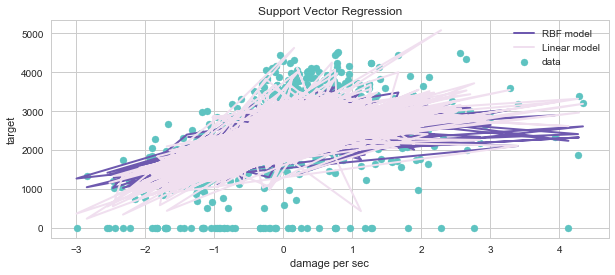

In [188]:
plt.figure(figsize = (10, 4))
y_lin = fitted_lin.predict(X_test)
y_rbf = fitted_rbf.predict(X_test)

lw = 2
plt.scatter(X_test.damage_per_sec, y_test, 
            color = '#5EC3C1', label = 'data')
plt.plot(X_test.damage_per_sec, y_rbf, color = '#6E59AF', lw = lw, label = 'RBF model')
plt.plot(X_test.damage_per_sec, y_lin, color = '#F0DFEF', lw = lw, label = 'Linear model')
plt.xlabel('damage per sec')
plt.ylabel('target')
plt.title('Support Vector Regression')
plt.legend()
plt.show()

A model seems to "cover up" most of the variance in the dataset. But we can try improving the model (`rbf` kernel) by extending the grid search: 
- `C` values > 100 
- `gamma` values < 0.01
- `epsilon` > 1

In the meantime, we don't want to make it "too much". For example, very small `gammas` would not enable capturing the "shape" of the data, so smoothing them. And too large `C` values would definetly overfit the data by trying to catch every fluctuation in the dataset. 

So it's important to balance these two. 

__In our case, we will try creating smooth models (lower `gamma` values) to which we add more complexity by selecting a larger number of support vectors (larger `C` values).__

In [151]:
C_range = 10. ** np.arange(3, 6)
gamma_range = 10. ** np.arange(-6, -3)
epsilon = range(list(2, 10, 2))
param_rbf = dict(C = C_range, gamma = gamma_range, epsilon = epsilon)

grid_rbf = GridSearchCV(SVR(kernel = 'rbf'), param_grid = param_rbf, cv = 5) 
grid_rbf.fit(X_train, y_train)

# print the best combination
print("The best classifier is: ", grid_rbf.best_estimator_)

The best classifier is:  SVR(C=100000.0, cache_size=200, coef0=0.0, degree=3, epsilon=8, gamma=0.0001,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)


Let's see if C of 100000, gamma 0.001 and epsilon of 8 will improve the model's score.

In [153]:
# parameters grid search
model_rbf = SVR(kernel = 'rbf', C = 100000, gamma = 0.0001, epsilon = 8)

# fitting and predicting on the unseen data
fitted_rbf = model_rbf.fit(X_train, y_train)
fitted_rbf.score(X_test, y_test) # the R^2 of the prediction

0.5013715736582498

Not much, but it did. We could try going further into the woods and extend the grid, but even if it improved the score it wouldn't be significantly larger.

In [154]:
# cross validation scores
cv_scores = cross_val_score(fitted_rbf, X_test, y_test, cv = 5)
print(cv_scores)

[ 0.51821743  0.47497469  0.40052031  0.46167793  0.39697901]


In [155]:
# predictions
pred = fitted_rbf.predict(X_test)
pred

array([ 2361.7947664 ,  2466.12645941,  2630.85074142, ...,  2951.31176908,
        2916.71239882,  3111.36580537])

We see that predictions are floats, while the actual values are integers. But prediction is not the topic of this notebook.

#### - Top features

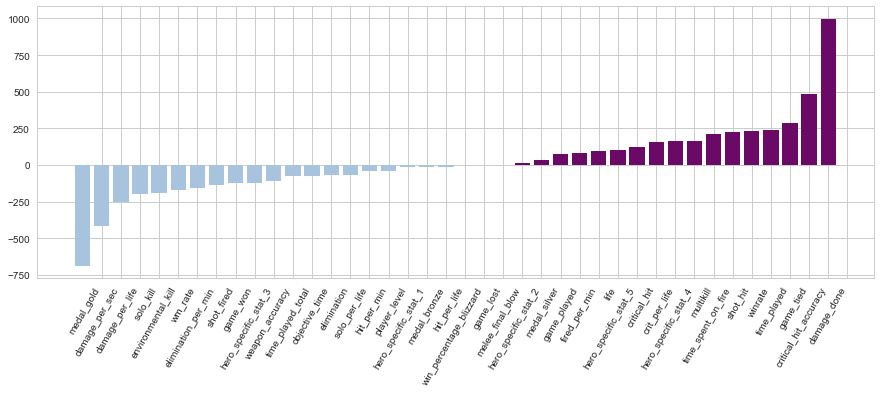

In [194]:
plt.figure(figsize = (15, 5))

def plot_coefficients(classifier, feature_names, top_features = 20):
    coef = classifier.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])# create plot
    colors = ['#A8C3DE' if c < 0 else '#6A0A66' for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
    plt.show()

cv = CountVectorizer()
cv.fit(data)

# linear kernel
svr = SVR(kernel = 'linear', C = 100, epsilon = 0.01)
svr.fit(X_train, y_train)

plot_coefficients(svr, cv.get_feature_names())

As we can see, the plot provides useful insight into what features are being used by the model to make the positive and negative classifications from the dataset. Notice that I used a linear classifier, instead of fitted radial basis function.

Interesting finding: eventhough the `player_level` is correlated to the `competitive_rank` variable it doesn't seem to contribute to the model. Instead, `damage_done` and `medal_gold` are most accurate predictors of the `competitive_rank`.

---

### Conclusion

A __widowmaker charachter is not the most popular character in the game__: about 80% of players don't play it at all. Therefore, we filtered the data and dropped the players who didn't play the character less than 5% of the total time spent in the game.

We have seen that __on average, each player respawned about 193 times__ during the time played for the character. Per each respawn, there is about 1'050 units of damage with the maximum amount of 10'350. By the way, __an average player does 13 units of damage per second or 780 per minute.__

Concerning different types of platforms, __PC and PlayStation players share the same competitivity characteristics__. We can clearly see an overlap of rank averages for both platforms. However, __PC users have the highest level of players__ among all platforms. Korean server was not taken into the comparison due to the lack of data. 

One of the main metrics, competitive rank of a player, seems to be positively and linearly correlated to the variables such as `damage_per_sec` (0.47), `elimination_per_min` (0.47), `weapon_accuracy` (0.46) and `player_level` (0.43). 

In reality though, only one of them __significantly contribute to the "decision" of the competitive rank of a player__, which is __`damage_per_sec`__. Other most "weighted" variables are __`damage_done`, `critical_hit_accuracy`__ and __`medal_gold`.__

Few things should be said about the algorythm we used. __If we decided to classify the data, to do a supervised learning, the Support Vector classifier would not be the best choice of an algorythm__. Eventhough we decreased the amount of __noise__ and the size of the dataset itself, the __classes__ (`platform_type` for instance) are very __overlapping__. The Naive Bayse Classifyer or Random Forest would most probably do a better job here.